In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score, davies_bouldin_score
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
from DBCV import DBCV
from sklearn.pipeline import Pipeline
import umap.umap_ as umap
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the dataset
X_train = pd.read_csv('data/training_data/preprocessed_data.csv')

In [19]:
def apply_scaling(data, method='standard',):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'standard', 'minmax', or 'robust'.")
    
    return scaler.fit_transform(data)


def apply_reduction(data, method='pca', random_state=42):
    if method == 'pca':
        reducer = PCA(n_components=0.99,random_state=random_state)
    elif method == 'umap':
        reducer = Pipeline([
            ('pca', PCA(n_components=0.99,random_state=random_state)),
            ('umap', umap.UMAP(n_components=10,random_state=random_state))
        ])
    else:
        raise ValueError("Invalid reduction method. Choose 'pca', or 'umap'.")
    
    return reducer.fit_transform(data)

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

def cluster_kmeans(data, n_clusters=20, random_state=42, init='k-means++',n_init=50):
    model = KMeans(n_clusters=n_clusters, random_state=random_state, init=init, n_init=n_init)
    labels = model.fit_predict(data)
    score = silhouette_score(data, labels, metric='euclidean')
    dbcv = DBCV(data, labels)
    return score, dbcv


In [ ]:
scaling_methods = ['standard', 'minmax', 'robust']
reduction_methods = ['pca', 'umap']

results = []

for scale in scaling_methods:
    data_scaled = apply_scaling(X_train, method=scale)
    for reduction in reduction_methods:
        data_scaled = apply_reduction(data_scaled, method=reduction)
        score = cluster_kmeans(data_scaled)
        print(f'kmeans {scale}, {reduction}, {score}')
        results.append({
            'Scaling': scale,
            'Reduction': reduction,
            'Clustering': 'kmeans',
            'Silhouette Score': score[0],
            'DBCV': score[1]
        })


kmeans standard, pca, (-0.007247721672050302, nan)
kmeans standard, umap, (0.40271837, -0.25177674985802456)
kmeans minmax, pca, (0.06658452541949708, nan)
kmeans minmax, umap, (0.47480947, -0.10981830247481551)
kmeans robust, pca, (0.7970337784597499, nan)
kmeans robust, umap, (0.6283501, 0.11349471817953978)


In [25]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform, euclidean, cityblock, cosine, minkowski
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


def cluster_hierarchical(data, method='average', metric='euclidean'):
    # Compute the distance matrix
    distance_matrix = pdist(data, metric=metric)
    # Perform hierarchical clustering
    distances = linkage(distance_matrix, method=method)
    # Form clusters with a max of 20 clusters
    clusters = fcluster(distances, 20, criterion='maxclust')
    # Compute the silhouette score
    score = silhouette_score(data, clusters, metric=metric)
    if metric == 'euclidean':
        dbcv = DBCV(data, clusters, dist_function=euclidean)
    elif metric == 'cityblock':
        dbcv = DBCV(data, clusters, dist_function=cityblock)
    elif metric == 'cosine':
        dbcv = DBCV(data, clusters, dist_function=cosine)
    elif metric == 'minkowski':
        dbcv = DBCV(data, clusters, dist_function=minkowski)
    return score, dbcv

In [26]:
scaling_methods = ['standard', 'minmax', 'robust']
reduction_methods = ['pca', 'umap']
metrics = ['euclidean', 'minkowski', 'cosine', 'cityblock']    
methods = ['centroid', 'single', 'complete', 'average']



for scale in scaling_methods:
    data_scaled = apply_scaling(X_train, method=scale)
    for reduction in reduction_methods:
        data_scaled = apply_reduction(data_scaled, method=reduction)
        for metric in metrics:
            for method in methods:
                score = cluster_hierarchical(data_scaled, method=method, metric=metric)
                print(f'hierarchical {metric}, {method},{scale}, {reduction},  {score}')
                results.append({
                    'Scaling': scale,
                    'Reduction': reduction,
                    'Clustering': f'hierarchical ({metric}, {method})',
                    'Silhouette Score': score[0],
                    'DBCV': score[1]
                })


hierarchical euclidean, centroid,standard, pca,  (0.2999352117719329, nan)
hierarchical euclidean, single,standard, pca,  (0.27534315126091863, nan)
hierarchical euclidean, complete,standard, pca,  (0.08942083554963297, nan)
hierarchical euclidean, average,standard, pca,  (0.2742493843720618, nan)
hierarchical minkowski, centroid,standard, pca,  (0.29993521177193294, nan)
hierarchical minkowski, single,standard, pca,  (0.27534315126091846, nan)
hierarchical minkowski, complete,standard, pca,  (0.08942083554963301, nan)
hierarchical minkowski, average,standard, pca,  (0.2742493843720616, nan)
hierarchical cosine, centroid,standard, pca,  (-0.13243987252944436, nan)
hierarchical cosine, single,standard, pca,  (-0.11834172093696667, nan)
hierarchical cosine, complete,standard, pca,  (0.09271691741723177, nan)
hierarchical cosine, average,standard, pca,  (0.10661585593475056, nan)
hierarchical cityblock, centroid,standard, pca,  (0.11146745486235744, nan)
hierarchical cityblock, single,sta

In [27]:
from sklearn.mixture import GaussianMixture

def cluster_gmm(data):
    # Create and fit the Gaussian Mixture Model
    model = GaussianMixture(n_components=20, random_state=42)
    model.fit(data)
    # Predict the labels
    labels = model.predict(data)
    # Calculate the silhouette score
    score = silhouette_score(data, labels)
    dbcv = DBCV(data, labels)
    return score, dbcv

In [ ]:
for scale in scaling_methods:
    data_scaled = apply_scaling(X_train, method=scale)
    for reduction in reduction_methods:
        data_reduced = apply_reduction(data_scaled, method=reduction)
        score = cluster_gmm(data_reduced)
        print(f'gmm {scale}, {reduction}, {score}')
        results.append({
            'Scaling': scale,
            'Reduction': reduction,
            'Clustering': 'GMM',
            'Silhouette Score': score[0],
            'DBCV': score[1]
        })

gmm standard, pca, (0.019572040559840236, nan)
gmm standard, umap, (0.36513078, -0.29090431641599557)
gmm minmax, pca, (0.046940972980097403, nan)
gmm minmax, umap, (0.42115116, -0.2667946365883596)
gmm robust, pca, (0.3655541149529165, nan)
gmm robust, umap, (0.6001498, -0.0845215063012831)


In [ ]:
df_results = pd.DataFrame(results)

,Scaling,Reduction,Clustering,Silhouette Score,DBCV
0,standard,pca,kmeans,"(-0.007247721672050302, nan)",NaN
1,standard,umap,kmeans,"(0.40271837, -0.25177674985802456)",-0.251777
2,minmax,pca,kmeans,"(0.06658452541949708, nan)",NaN
3,minmax,umap,kmeans,"(0.47480947, -0.10981830247481551)",-0.109818
4,robust,pca,kmeans,"(0.7970337784597499, nan)",NaN
...,...,...,...,...,...
167,standard,umap,GMM,0.365131,-0.290904
168,minmax,pca,GMM,0.046941,NaN
169,minmax,umap,GMM,0.421151,-0.266795
170,robust,pca,GMM,0.365554,NaN


In [44]:
import math

# Filter results to include only entries with valid (non-nan, non-None) DBCV values
valid_results = [entry for entry in results if entry.get("DBCV") is not None and not math.isnan(entry["DBCV"])]

# Find the entry with the maximum DBCV
if valid_results:
    best_params = max(valid_results, key=lambda x: x["DBCV"])
    print("Best Parameters:\n", best_params)
else:
    print("No valid DBCV values found.")

Best Parameters:
 {'Scaling': 'standard', 'Reduction': 'umap', 'Clustering': 'hierarchical (cosine, complete)', 'Silhouette Score': 0.53716844, 'DBCV': 0.804833106757622}


In [ ]:
max_dbcv = df_results['DBCV'].dropna().max()

0.804833106757622

In [41]:
# Convert results to DataFrame
df_results.sort_values(by = ["DBCV"], ascending=[False]).head(10).reset_index(drop=True)

,Scaling,Reduction,Clustering,Silhouette Score,DBCV
0,standard,umap,"hierarchical (cosine, complete)",0.537168,0.804833
1,minmax,umap,"hierarchical (cosine, average)",0.648647,0.751995
2,minmax,umap,"hierarchical (cosine, centroid)",0.635098,0.749492
3,standard,umap,"hierarchical (cosine, centroid)",0.577513,0.724675
4,standard,umap,"hierarchical (cosine, average)",0.576415,0.724675
5,minmax,umap,"hierarchical (cosine, complete)",0.569306,0.698684
6,robust,umap,"hierarchical (cosine, centroid)",0.746412,0.553996
7,robust,umap,"hierarchical (cosine, complete)",0.765379,0.550796
8,robust,umap,"hierarchical (cosine, average)",0.773432,0.544635
9,robust,umap,"hierarchical (cityblock, single)",0.578943,0.420953


In [3]:
from scipy.spatial.distance import cdist

class HierarchicalModel:
    def __init__(self, n_clusters=20, method='average', metric='euclidean'):
        self.n_clusters = n_clusters
        self.method = method
        self.metric = metric
        self.fit_data = None  # This will store the data after fitting
        self.fit_clusters = None  # This will store the clusters after fitting
    
    def fit_predict(self, data):
        self.fit_data = data  # Store the fitting data
        # Compute the pairwise distance matrix
        distance_matrix = pdist(self.fit_data, metric=self.metric)
        # Perform hierarchical clustering
        distances = linkage(distance_matrix, method=self.method)
        # Assign clusters
        clusters = fcluster(distances, self.n_clusters, criterion='maxclust')
        self.fit_clusters = clusters  # Store the clusters
        return clusters, distances

    def predict(self, new_data):
        if self.fit_data is None:
            raise ValueError("Model has not been fitted yet. Please call fit_predict first.")
        unique_clusters = np.unique(self.fit_clusters)
        centroids = np.array([np.mean(self.fit_data[self.fit_clusters == i], axis=0) for i in unique_clusters])
        print(centroids.shape)
        distances_to_centroids = cdist(new_data, centroids, metric=self.metric)
        predicted_clusters = unique_clusters[np.argmin(distances_to_centroids, axis=1)]
        return predicted_clusters


In [46]:
data_scaled = apply_scaling(X_train, method = best_params['Scaling'])
data_reduced = apply_reduction(data_scaled, method = best_params['Reduction'])
if best_params['Clustering']=='kmeans':
    model = KMeans(n_clusters=20, random_state=42, init='k-means++', n_init=50)
    labels = model.fit_predict(data_reduced)

elif best_params['Clustering']=='GMM':
    model = GaussianMixture(n_components=20, random_state=42)
    model.fit(data_reduced)
    labels = model.predict(data_reduced)

elif best_params['Clustering'].startswith('hierarchical'):
    method = best_params['Clustering'].split('(')[1].split(')')[0].split(',')[1]
    metric = best_params['Clustering'].split('(')[1].split(')')[0].split(',')[0]
    
    # Clean up the method and metric
    method = method.lower().strip()
    metric = metric.lower().strip()
    
    '''
    In AgglomerativeClustering, sklearn does not support predict method which preform prediction on new data
    We can compute centroids of each cluster and assign the new data point to the nearest centroid 
    '''
    model = HierarchicalModel(n_clusters=20, method=method, metric=metric)
    labels = model.fit_predict(data_reduced)[0]

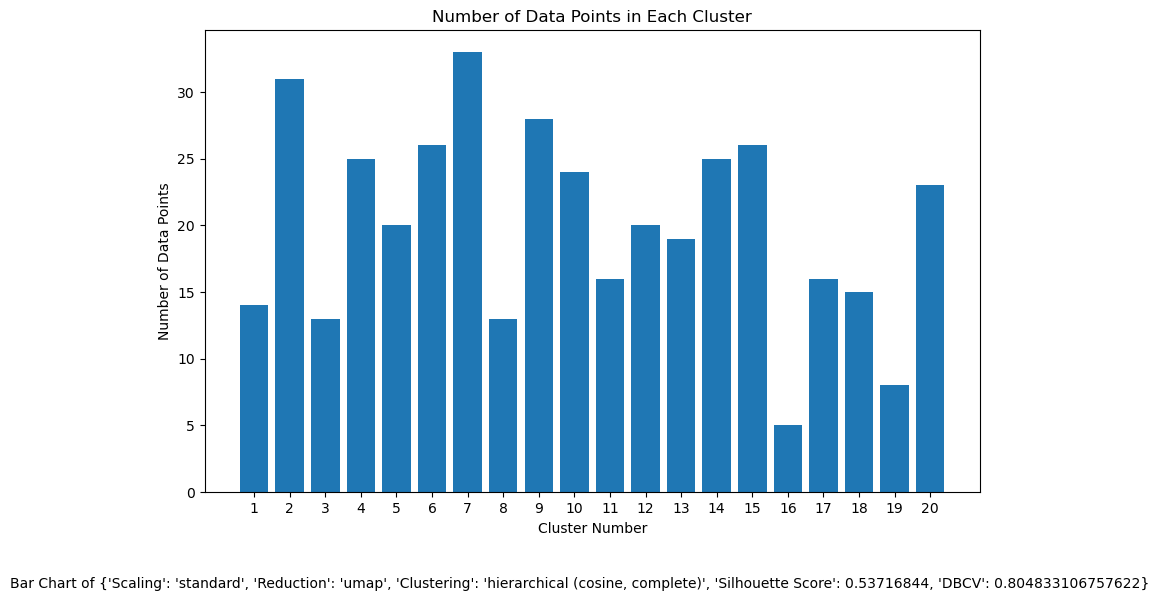

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of data points in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=unique_labels)
plt.xlabel('Cluster Number')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in Each Cluster')
plt.xticks(unique_labels)  # Show all cluster numbers as x-ticks

# Add a text description below the chart
plt.figtext(0.5, -0.05, f"Bar Chart of {best_params}", ha='center', fontsize=10)

plt.show()


In [48]:
# Plot images in each cluster
umist_data = pd.read_csv("umist_cropped.csv")

In [49]:
umist_data['cluster_id'] = labels

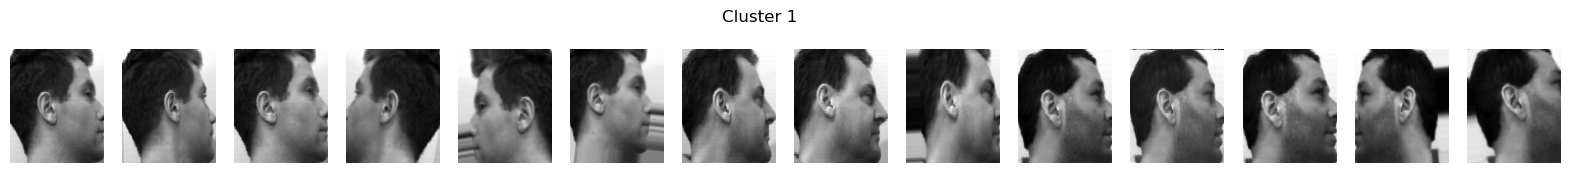

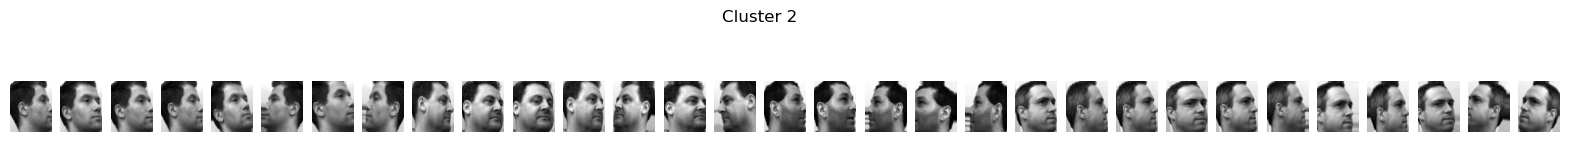

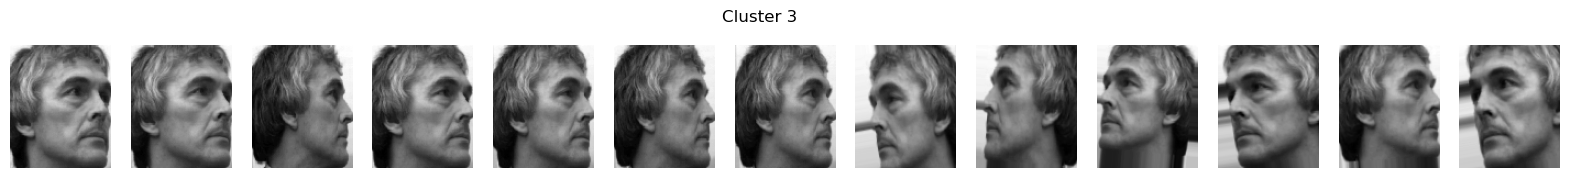

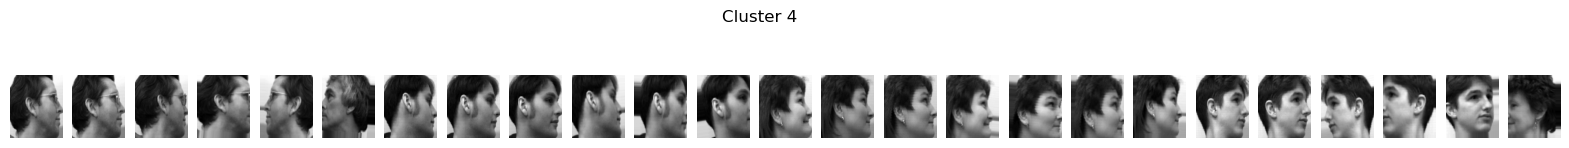

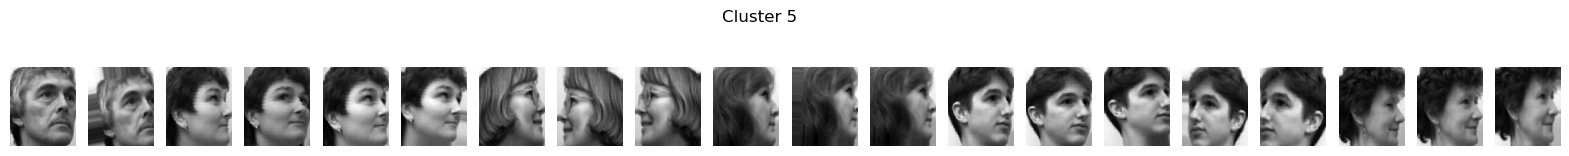

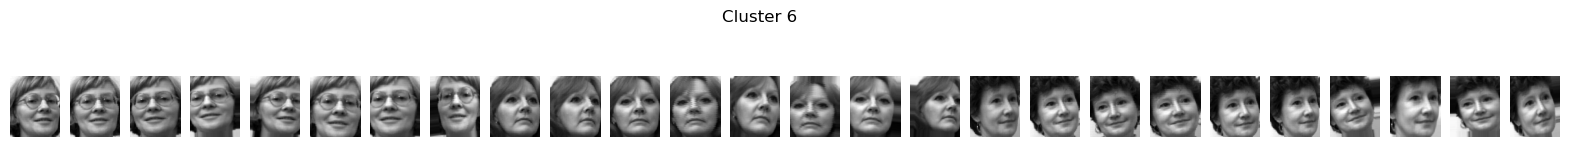

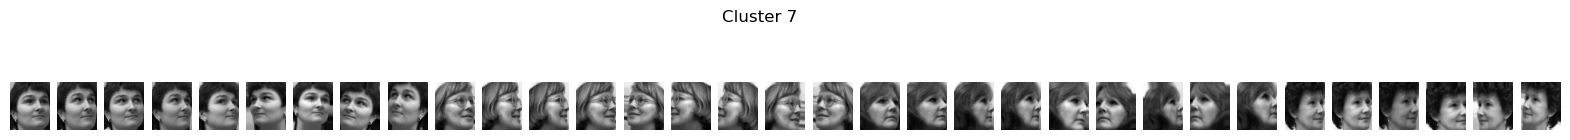

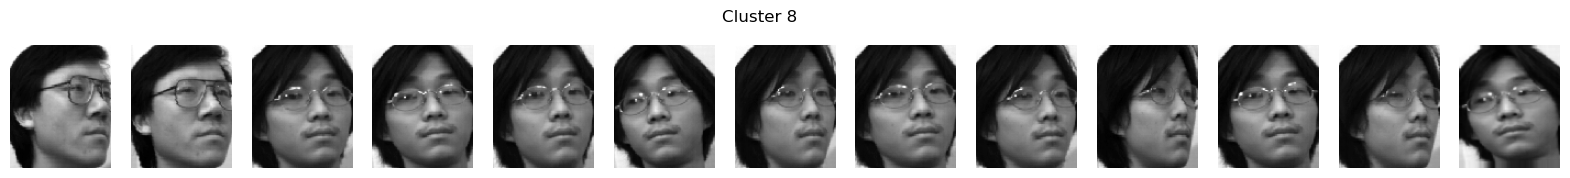

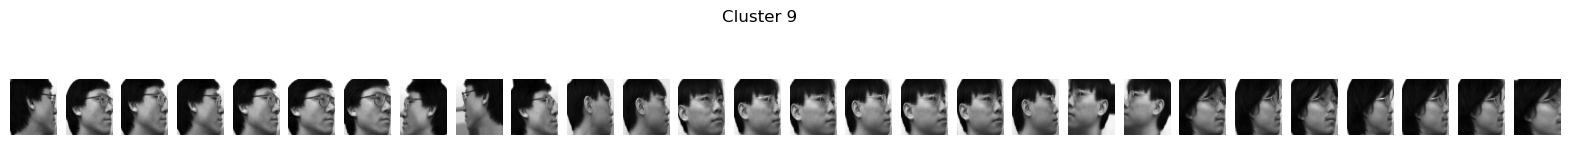

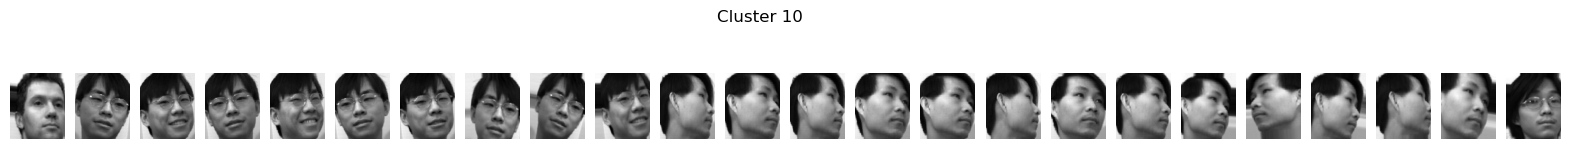

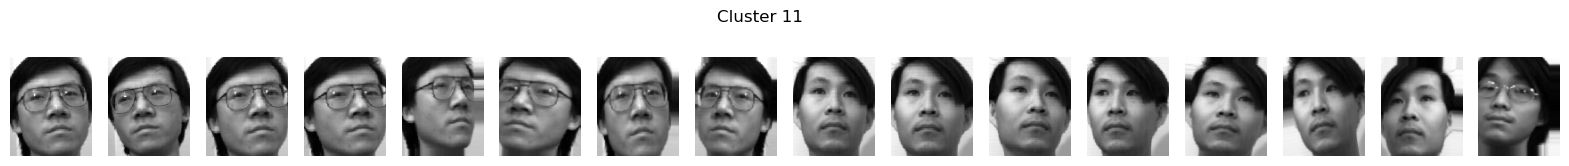

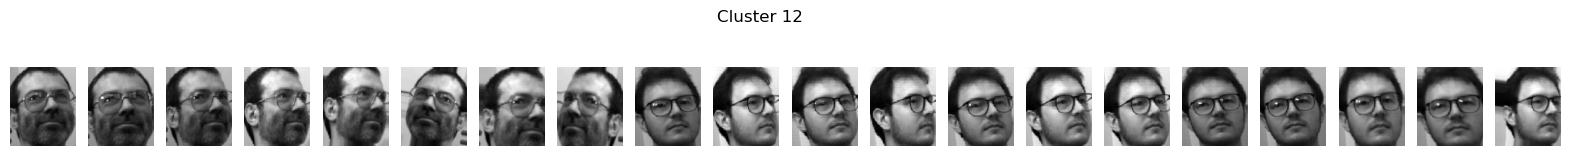

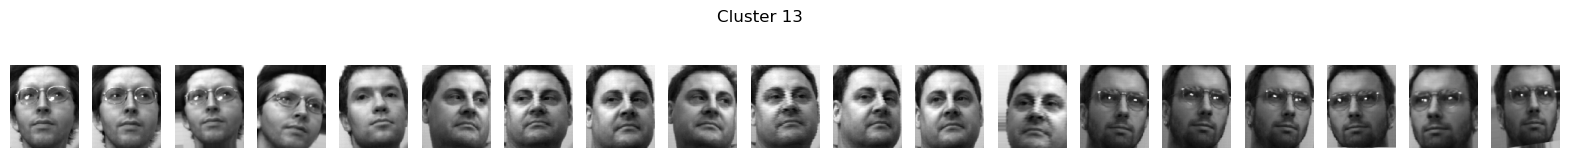

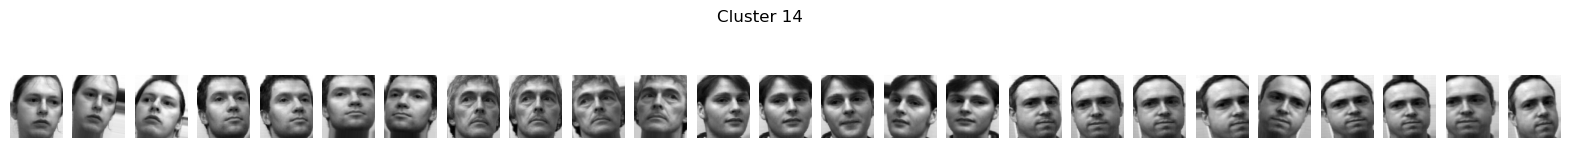

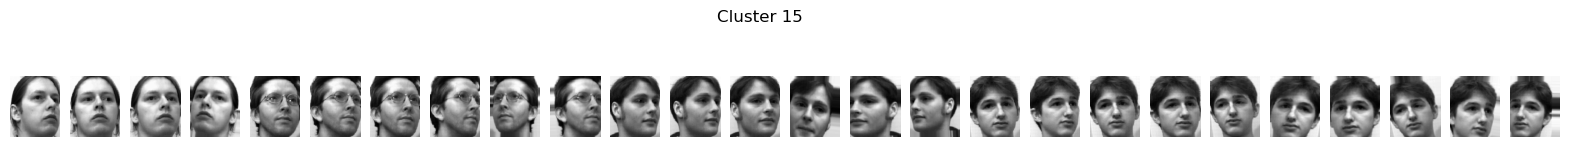

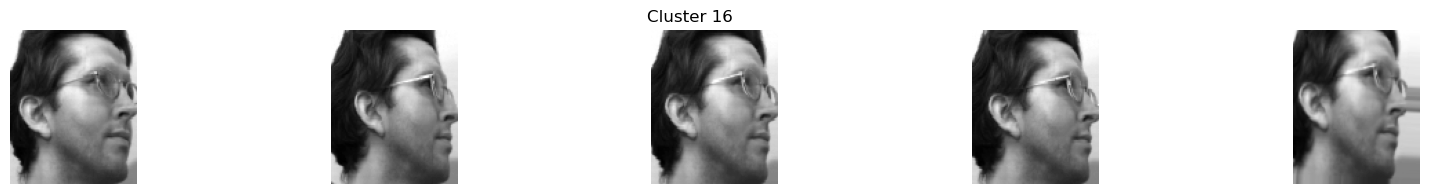

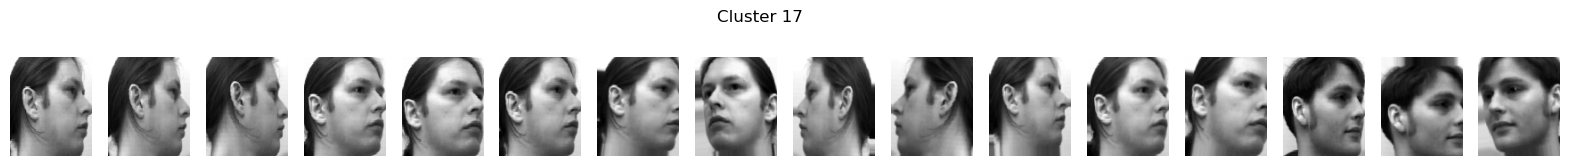

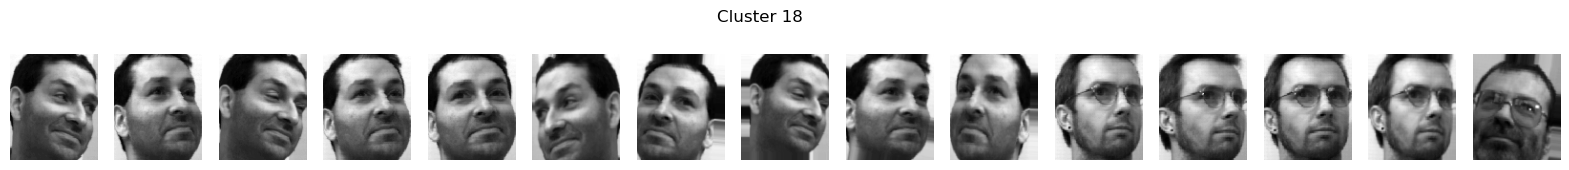

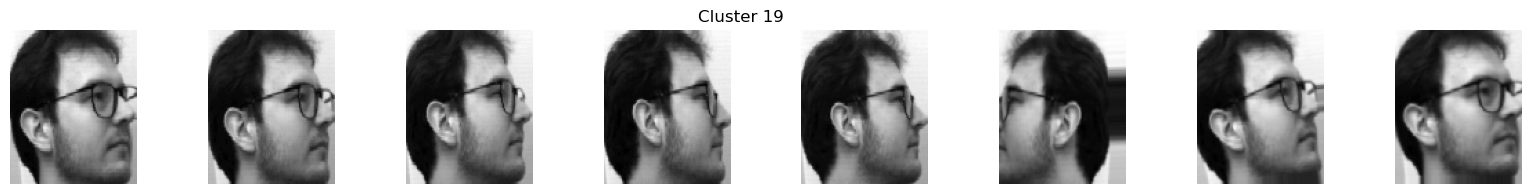

In [50]:
from collections import Counter
for cluster_id in range(20):
    cluster_indices = umist_data[umist_data['cluster_id'] == cluster_id].index
    num_images = min(max(Counter(labels).values()), len(cluster_indices))
    
    if num_images > 0:
        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        
        for i in range(num_images):
            img_idx = cluster_indices[i]
            img = umist_data.iloc[img_idx, :-1].values.reshape(112, 92)
            
            if num_images == 1:
                axes.imshow(img, cmap='gray')
                axes.axis('off')
            else:
                axes[i].imshow(img, cmap='gray')
                axes[i].axis('off')
                
        fig.suptitle(f"Cluster {cluster_id}")
        plt.show()
            

In [51]:
scaler = None
pipeline = None

if best_params['Scaling'] == 'standard':
    scaler = StandardScaler()
elif best_params['Scaling'] == 'minmax':
    scaler = MinMaxScaler()
elif best_params['Scaling'] == 'robust':
    scaler = RobustScaler()
    
if best_params['Reduction'] == 'pca':
    pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', PCA(n_components=0.99, random_state=42))
])
elif best_params['Reduction'] == 'umap':
   pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', PCA(n_components=0.99, random_state=42)),
    ('umap', umap.UMAP(n_components=10, random_state=42))
])

In [4]:
import pandas as pd
X_val = pd.read_csv("data/validation_data/umist_val_for_cluster.csv")

In [53]:
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

In [54]:
predict = model.predict(X_val_transformed)

# if model is HierarchicalModel
if best_params['Clustering'].startswith('hierarchical'):
    # if metric is cityblock
    if best_params['Clustering'].split('(')[1].split(')')[0].split(',')[0] == 'cityblock':
        dbcv = DBCV(X_val_transformed, predict, dist_function=cityblock)
    # if metric is cosine
    elif best_params['Clustering'].split('(')[1].split(')')[0].split(',')[0] == 'cosine':
        dbcv = DBCV(X_val_transformed, predict, dist_function=cosine)
    # if metric is minkowski
    elif best_params['Clustering'].split('(')[1].split(')')[0].split(',')[0] == 'minkowski':
        dbcv = DBCV(X_val_transformed, predict, dist_function=minkowski)
else:
    dbcv = DBCV(X_val_transformed, predict)
    
    
print(f"DBCV Score on Validation Data: {dbcv}")
print(f"Silhouette Score on Validation Data: {silhouette_score(X_val_transformed, predict)}")

(20, 10)
DBCV Score on Validation Data: 0.8035248377041164
Silhouette Score on Validation Data: 0.32698994874954224


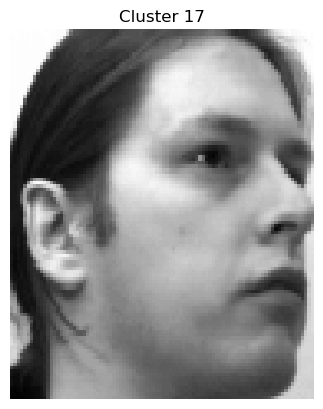

In [55]:
umist_data_val = pd.read_csv("umist_val.csv")

# Plot 1st image
img = umist_data_val.iloc[3].values.reshape(112, 92)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"Cluster {predict[3]}")
plt.show()

In [ ]:
# Save the best model and pipeline
import joblib

joblib.dump(model, "models/cluster/best_clustering_model.pkl")
joblib.dump(pipeline, "models/pipeline/best_pipeline.pkl")

['best_pipeline.pkl']